In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from pathlib import Path
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from utils import *
import time

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "dwt_combined_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
print(*image_dict.keys(), sep=', ')

Astrocitoma, Carcinoma, Ependimoma, Ganglioglioma, Germinoma, Glioblastoma, Granuloma, Meduloblastoma, Meningioma, Neurocitoma, Oligodendroglioma, Papiloma, Schwannoma, Tuberculoma, _NORMAL


### Load feature map

#### Embed the feature map

In [3]:
# Embed the data by PCA and TSNE if haven't
embed = False
if embed:
    data = pd.read_csv(os.path.join(data_path, 'image_value_dict.csv'))
    X, labels = data.iloc[:, :-1].to_numpy(), data.iloc[:, -1].to_numpy()
    X, labels
    
    # By PCA
    pca = PCA(n_components=64)
    y = pd.factorize(labels)[0]
    pca_X = pca.fit_transform(X)

    data = pd.DataFrame(pca_X)
    data['label'] = labels
    data.to_csv(os.path.join(data_path, "pca_image_value_dict.csv"), index=False)

    plt.figure()
    plt.title('Embedding of feature map on first and second principle components')
    plt.scatter(pca_X[:, 0], pca_X[:, 1], c=y)

    # By TSNE
    tsne = TSNE(n_components=64, method='exact', learning_rate='auto', init='random', perplexity=3)
    tsne_X = tsne.fit_transform(X)

    data = pd.DataFrame(tsne_X)
    data['label'] = labels
    data.to_csv(os.path.join(data_path, "tsne_image_value_dict.csv"), index=False)
    
# Else load the saved data by guven method:
embed_method = 'tsne' # or 'pca'
data = pd.read_csv(os.path.join(data_path, embed_method+'_image_value_dict.csv'))
X, labels = data.iloc[:, :-1].to_numpy(), data.iloc[:, -1].to_numpy()
y = pd.factorize(labels)[0]
print(X.shape)
X, labels

(4478, 64)


(array([[-0.1932285 ,  0.43204862, -0.35730872, ...,  0.29469192,
          0.1649177 , -0.37778986],
        [-0.12363593, -0.09538125, -1.0944743 , ...,  1.1734923 ,
          0.06099137, -0.773806  ],
        [ 0.49205416, -0.37170497,  0.745595  , ..., -0.29842043,
         -1.274907  ,  0.12614979],
        ...,
        [-0.19574082, -0.10772687,  0.18486801, ...,  0.5652172 ,
          0.04326718,  0.574701  ],
        [-0.06718548,  0.3974936 , -1.2135364 , ...,  1.2631209 ,
          0.57759714, -0.70968354],
        [ 0.6078855 ,  0.25251848, -0.14807133, ...,  0.30003974,
          0.4284362 , -0.32612237]]),
 array(['Astrocitoma', 'Astrocitoma', 'Astrocitoma', ..., '_NORMAL',
        '_NORMAL', '_NORMAL'], dtype=object))

##### By TSNE

In [4]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([396, 171, 105,  42,  68, 144,  54,  95, 633, 325, 151, 169, 314,
       103, 364]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([183,  80,  45,  19,  32,  60,  24,  36, 241, 132,  73,  68, 151,
        42, 158]))


### SVM

In [5]:
svm = SVC(kernel='rbf', gamma='auto')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,  average='micro'))

Accuracy: 0.33035714285714285
Precision: 0.33035714285714285
Recall: 0.33035714285714285


### Random Forest - XGBoost

In [6]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred,  average='micro'))

Accuracy: 0.20461309523809523
Precision: 0.20461309523809523
Recall: 0.20461309523809523


### Simple MLP

In [7]:
learning_rate = 3e-2
batch_size = 256
epochs = 50
n_classes = len(np.unique(y))

In [8]:
class BrainTumorDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(X)

    def __getitem__(self, idx):
        X_i = self.X[idx]
        y_i = self.y[idx]
        
        return X_i, y_i

In [9]:
class SimpleMLP(torch.nn.Module):

    def __init__(self, n_class):
        super(SimpleMLP, self).__init__()
        self.mlp = torch.nn.Sequential(torch.nn.Linear(64, 128),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(128, 256),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(256, 128),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(128, 64),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(64, 32),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(32, 16),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(16, n_class),)
                                       #torch.nn.Softmax(dim=1))

    def forward(self, x):
        x = self.mlp(x)
        return x

model = SimpleMLP(n_classes).type(torch.float64)

In [11]:
train_dataset = BrainTumorDataset(X, y)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test_dataset = BrainTumorDataset(test_image_dict, data_path, transform=transforms.ToTensor())
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#val_dataset = BrainTumorDataset(val_image_dict, data_path, transform=transforms.ToTensor())
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [12]:
loss_fn = nn.CrossEntropyLoss()
#params = [p for p in vgg19.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

------------ Epoch: 0 ------------
Training loss: 1.189704, validation loss: 0.000000
Time elapsed: 0.952988862991333
------------ Epoch: 1 ------------
Training loss: 1.189349, validation loss: 0.000000
Time elapsed: 0.0416715145111084
------------ Epoch: 2 ------------
Training loss: 1.188900, validation loss: 0.000000
Time elapsed: 0.039703369140625
------------ Epoch: 3 ------------
Training loss: 1.188435, validation loss: 0.000000
Time elapsed: 0.03572225570678711
------------ Epoch: 4 ------------
Training loss: 1.187954, validation loss: 0.000000
Time elapsed: 0.034783363342285156
------------ Epoch: 5 ------------
Training loss: 1.187429, validation loss: 0.000000
Time elapsed: 0.0352787971496582
------------ Epoch: 6 ------------
Training loss: 1.186901, validation loss: 0.000000
Time elapsed: 0.03485274314880371
------------ Epoch: 7 ------------
Training loss: 1.186334, validation loss: 0.000000
Time elapsed: 0.03690505027770996
------------ Epoch: 8 ------------
Training l

Text(0.5, 0, 'Epoch')

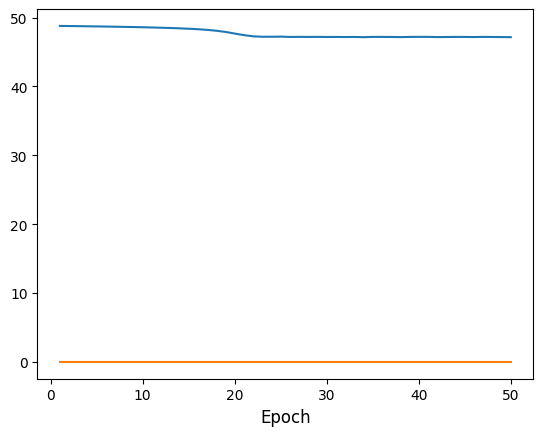

In [13]:
model.to(device)
all_loss = []
all_valid_loss = []
for epoch in range(epochs):
    size = len(train_dataloader.dataset)
    print("------------ Epoch:", epoch, "------------")
    training_loss = 0
    valid_loss = 0
    start = time.time()
    for batch, (train_X, train_y) in enumerate(train_dataloader):
        # Compute prediction and loss
        pred = model(train_X.to(device))
        #print(torch.sum(pred[0]))
        loss = loss_fn(pred, train_y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (batch + 1) * len(X)
        #print(loss)
        training_loss += loss
        
    print(f"Training loss: {training_loss/41:>7f}, validation loss: {valid_loss/41:>7f}")
    end = time.time()
    print("Time elapsed:", end - start)
    all_loss.append(training_loss)
    all_valid_loss.append(valid_loss)

fig = plt.figure()
plt.plot(range(1, epochs+1), all_loss)
plt.plot(range(1, epochs+1), all_valid_loss)
plt.xlabel('Epoch', fontsize=12)